In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
 cd drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow_addons as tfa
import datetime
import tensorflow as tf
import os
from dataloader_update import Dataset
import numpy as np

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)

#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
print(tf.__version__)


2.2.0


In [ ]:
split_dict = {'IXMAS': { 
	'allocentric': {
		'train':['cam0','cam1','cam2','cam3'],
		'test':['cam4']},
	'lateral': {
		'train':['cam0','cam3'],
		'test':['cam1','cam2','cam4']},
	'simple': {
		'train':['cam0','cam1','cam2'],
		'test':['cam3']},
	'crazy': {
		'train':['cam0'],
		'test':['cam4']}
						},
			    'MOCA':{
	'01': {
	    'train':['0'],
	    'test':['1']},
	'02': {
	    'train':['0'],
	    'test':['2']},
	'12': {
	    'train':['1'],
	    'test':['2']},  
	'10': {
	    'train':['1'],
	    'test':['0']},
	'20': {
	    'train':['2'],
	    'test':['0']},
	'21': {
	    'train':['2'],
	    'test':['1']},	
	'01_2': {
	    'train':['0', '1'],
	    'test':['2']},
	'02_1': {
	    'train':['0', '2'],
	    'test':['1']},
	'12_0': {
	    'train':['1', '2'],
	    'test':['0']},
			    }
			 }

def return_numpy(input):
	return input.numpy()

In [ ]:
dataset = Dataset(batch_size = 12, name = 'IXMAS', data_path_index= 0)
dataset.load_dataset_paths()


In [ ]:

dataset.crossview_split(split_dict['IXMAS']['crazy'])


In [ ]:
dataset.select_features_to_save()

In [ ]:
import os
def ensure_dir(file_path):
  directory = os.path.dirname(file_path)
  if not os.path.exists(directory):
      os.makedirs(directory)
def save_model(model, path_to_save):
  ensure_dir(path_to_save)
  tf.keras.models.save_model(model.predict_label, path_to_save + '/action_classifier')
  tf.keras.models.save_model(model.feature_extractor, path_to_save + '/feature_refiner')
  tf.keras.models.save_model(model.domain_classifier, path_to_save + '/view_classifier')

def save_features(dataset, model, epoch, run_name = 'datasetname_split', saving_model = False, saving_features = True):
  dataset_name, split = run_name.split('_')
  if saving_model:
    model_path = '../models/'+ dataset_name + '_' + split + '/epoch' + str(epoch+1)
    save_model(model, model_path)
  if saving_features:
    for i in range(len(dataset.source_features)):
      original_features, shape = dataset.source_features[i], dataset.source_features[i].shape
      original_path = dataset.source_to_save[i][0]
      filename = original_path.split('/')[-1]
      action = filename.split('_')[0]
      downsampled = model.return_downsampled_features(original_features.reshape(1,*shape)) 
      path_to_save = '../forTSNE/'+ dataset_name + '/' + split + '_epoch' + str(epoch+1) + '_source/' + action + '/' + filename
      ensure_dir(path_to_save)
      np.save(path_to_save,downsampled)
      print('source',path_to_save)
    for i in range(len(dataset.test_features)):
      original_features, shape = dataset.test_features[i], dataset.test_features[i].shape
      original_path = dataset.test_to_save[i][0]
      filename = original_path.split('/')[-1]
      action = filename.split('_')[0]
      downsampled = model.return_downsampled_features(original_features.reshape(1,*shape))    
      path_to_save = '../forTSNE/'+ dataset_name + '/' + split + '_epoch' + str(epoch+1) + '_test/' + action + '/' + filename
      ensure_dir(path_to_save)
      np.save(path_to_save,downsampled)
      print('test',path_to_save)
    for i in range(len(dataset.target_features)):
      original_features, shape = dataset.target_features[i], dataset.target_features[i].shape
      original_path = dataset.target_to_save[i][0]
      filename = original_path.split('/')[-1]
      action = filename.split('_')[0]
      downsampled = model.return_downsampled_features(original_features.reshape(1,*shape))
      directory = '../forTSNE/'+ dataset_name + '/' + split + '_epoch' + str(epoch+1) + '_target/' + action + '/'
      path_to_save =  directory + filename
      ensure_dir(path_to_save)
      np.save(path_to_save,downsampled)
      print('target',path_to_save)



In [ ]:
dataset.test_to_save

In [ ]:
dataset.converter()
num_classes = 11
width, height = 7, 7
num_channels = 832
input_shape = (8, width, height, num_channels)



In [ ]:
@tf.custom_gradient
def GradientReversalOperator(x):
    def grad(dy):
        #tf.print(tf.math.reduce_mean(dy))
        return -1 * dy
    return x, grad

class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(GradientReversalLayer, self).__init__()
        
    def call(self, inputs):
        return GradientReversalOperator(inputs)


In [ ]:

import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, Conv3D
from tensorflow.keras.regularizers import l2

MAX_STEP = 10000

log_format = 'L1 Test: {:.4f}, Acc1 Test: {:.2f}\n'+ \
    'L2 Test: {:.4f}, Acc2 Test: {:.2f}\n'+ \
    'L3 Test: {:.4f}, Acc3 Test: {:.2f}\n'

log_format_source_only = 'L1 Test: {:.4f}, Acc1 Test: {:.2f}\n' + \
    'L1 Target_1: {:.4f}, Acc3 Target_1: {:.2f}\n' + \
    'L1 Target_2: {:.4f}, Acc3 Target_2: {:.2f}\n'


In [ ]:
class InvertedLoss(tf.keras.losses.Loss):

    def __init__(self, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE, name='InvertedLoss'):
        super().__init__(reduction=reduction, name=name)
    
    @tf.function 
    def call(self, y_true, y_pred, lp_loss = 1):
        standard_loss = tf.keras.losses.SparseCategoricalCrossentropy()
        #return tf.math.maximum(standard_loss(y_true, y_pred),tf.math.log(tf.divide(tf.constant(1.0, dtype = 'float32'),(standard_loss(y_true, y_pred)))))
        #return tf.math.maximum(standard_loss(y_true, y_pred), tf.multiply(2.0, tf.math.exp(tf.multiply(-1.0, tf.math.square(standard_loss(y_true, y_pred))))))
        return tf.multiply(1.0, tf.math.exp(tf.multiply(-1.0, tf.math.abs(standard_loss(y_true, y_pred)))))

In [ ]:
class EuclideanDistanceLoss(tf.keras.losses.Loss):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    def __init__(self, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE, name='EuclideanDistanceLoss'):
        super().__init__(reduction=reduction, name=name)
    def call(self, y_true, y_pred):
      return 0.5 * tf.math.sqrt(tf.math.reduce_sum(tf.math.square(y_true - y_pred), axis=-1))

In [ ]:

import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling3D, Flatten, Dense, Dropout, Conv3D, UpSampling3D
from tensorflow.keras.regularizers import l2


MAX_STEP = 10000

log_format = 'L1 Test: {:.4f}, Acc1 Test: {:.2f}\n'+ \
    'L2 Test: {:.4f}, Acc2 Test: {:.2f}\n'+ \
    'L3 Test: {:.4f}, Acc3 Test: {:.2f}\n'

log_format_source_only = 'L1 Test: {:.4f}, Acc1 Test: {:.2f}\n' + \
    'L1 Target_1: {:.4f}, Acc3 Target_1: {:.2f}\n' + \
    'L1 Target_2: {:.4f}, Acc3 Target_2: {:.2f}\n'



class Upsample():
    def __init__(self, input_shape = input_shape, run_name = 'multiclass', lr = [0.1, 0.1, 0.1], source_only=False, category = (None, None)):
        super(Upsample, self).__init__()

        self.downsample = Sequential([
                                             
            Conv3D(filters=128, kernel_size=[5,5,5], kernel_regularizer=l2(0.001), padding='same', input_shape=input_shape),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling3D([2,2,2]),
            Conv3D(filters=64,kernel_size=[3,3,3], kernel_regularizer=l2(0.001), padding='same'),
            Activation('relu'),
            Conv3D(filters=32,kernel_size=[2,2,2], kernel_regularizer=l2(0.001), padding='same'),
            Activation('relu'),
            Conv3D(filters=32,kernel_size=[2,2,2], kernel_regularizer=l2(0.001), padding='same'),
            Activation('relu')
            ])
        
        self.upsample = Sequential([
            UpSampling3D([3,2,2]), 
            BatchNormalization(),
            Activation('tanh')                    
        ])
        self.label_predictor = Sequential([
            Flatten(),
            #Dense(128, activation='relu'),
            #BatchNormalization(),
            Dropout(0.6),
            Dense(11, activation = None),
            BatchNormalization(),
            Activation('softmax')
        ])
            
        self.feature_extractor = Sequential([
            self.downsample,
            self.upsample                       
        ])

        self.domain_classifier = Sequential([
            GradientReversalLayer(),                                 
            Conv3D(filters=128, kernel_size=[3,3,3], kernel_regularizer=l2(0.001), padding='same'),
            Activation('relu'),
            MaxPooling3D(pool_size = (2,2,2)),
            Conv3D(filters=128, kernel_size=[2,2,2], kernel_regularizer=l2(0.001), padding='same'),
            Activation('relu'),
            Flatten(),
            #Dense(128, kernel_regularizer=l2(0.001)),
            #BatchNormalization(),
            Activation('relu'),
            Dropout(0.6),
            Dense(3, activation='softmax'),
                    
            ])
        
       # self.domain_classifier2 = Sequential([
       #     GradientReversalLayer(),
       #     Flatten(),
       #     Dropout(0.5),
       #     Dense(5, activation='softmax')
       # ])
        
        self.predict_label = Sequential([
            self.feature_extractor,
            self.label_predictor
            ])

        self.classify_domain = Sequential([
            self.feature_extractor,
            self.domain_classifier
            ])
        
        #self.classify_domain2 = Sequential([
        #    self.downsample,
        #    self.domain_classifier2
        #    ])
        
        
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy()
        self.inv_loss = InvertedLoss()
        self.lp_lr = lr[0]
        self.dc_lr = lr[1]
        self.fe_lr = lr[2]
        #from keras_radam import RAdam

        
        #self.lp_optimizer = tf.keras.optimizers.Nadam(learning_rate=self.lp_lr)
        #self.dc_optimizer = tf.keras.optimizers.Nadam(learning_rate=self.dc_lr)
        #self.fe_optimizer = tf.keras.optimizers.Nadam(learning_rate=self.fe_lr) #fe_lr=0.0005
        #self.radam = tfa.optimizers.RectifiedAdam(lr=1e-3, total_steps=10000, warmup_proportion=0.1, min_lr=1e-6)
        #self.ranger = tfa.optimizers.Lookahead(self.radam, sync_period=6, slow_step_size=0.5)
        #self.lp_optimizer = self.ranger
        #self.dc_optimizer = self.ranger
        #self.fe_optimizer = self.ranger

        self.lp_optimizer = tf.keras.optimizers.SGD(learning_rate=self.lp_lr)
        self.dc_optimizer = tf.keras.optimizers.SGD(learning_rate=self.dc_lr)
        self.fe_optimizer = tf.keras.optimizers.SGD(learning_rate=self.fe_lr)

        #self.lp_optimizer = tf.keras.optimizers.Adam(learning_rate=self.lp_lr, decay=0.0005)
       # self.dc_optimizer = tf.keras.optimizers.Adam(learning_rate=self.dc_lr, decay=0.0002)
       # self.fe_optimizer = tf.keras.optimizers.Adam(learning_rate=self.fe_lr, decay = 0.0002) #fe_lr=0.0005

        self.train_lp_loss = tf.keras.metrics.Mean()
        self.train_dc_loss = tf.keras.metrics.Mean()
        
        self.train_lp_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        self.train_dc_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        self.test_lp_loss = tf.keras.metrics.Mean()
        self.test_dc_loss = tf.keras.metrics.Mean()
        self.test_target_lp_loss = tf.keras.metrics.Mean()
        self.test_target_test_lp_loss = tf.keras.metrics.Mean()
        self.test_lp_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        self.test_dc_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        self.test_target_lp_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        self.test_target_test_lp_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        self.train_target_lp_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        self.euclidean_loss = EuclideanDistanceLoss()
        if source_only:
            self.target_accuracy_1 = tf.keras.metrics.SparseCategoricalAccuracy()
            self.target_accuracy_2 = tf.keras.metrics.SparseCategoricalAccuracy()
            self.target_loss_1 = tf.keras.metrics.Mean()
            self.target_loss_2 = tf.keras.metrics.Mean()

        self.create_logger(run_name, source_only, category)
    
    @tf.function
    def single_train(self, x_class, y_class, views_class, x_domain, views_domain, return_loss = False):
        domain_labels = tf.concat([views_class, views_domain], axis = 0)
        x_both = tf.concat([x_class, x_domain], axis = 0)

        with tf.GradientTape() as tape:
          y_class_pred = self.predict_label(x_class, training=True)
          lp_loss = tf.multiply(2.0, self.loss(y_class, y_class_pred))
          #tf.print('lp_loss', lp_loss)
          lp_grad = tape.gradient(lp_loss, self.predict_label.trainable_variables)

       # with tf.GradientTape() as tape:    
       #   y_domain_pred = self.classify_domain(x_both, training=True)
       #   inv_loss = self.inv_loss(domain_labels, y_domain_pred)
       #   tf.print('inv_loss', inv_loss)
       #°°   fe_grad = tape.gradient(inv_loss, self.classify_domain.trainable_variables)

        with tf.GradientTape(persistent = True) as tape:
          y_domain_pred = self.classify_domain(x_both, training=True)
          dc_loss = self.loss(domain_labels, y_domain_pred)
          
          #tf.print('dc_loss', dc_loss)
          dc_grad = tape.gradient(tf.multiply(3.0,dc_loss), self.domain_classifier.trainable_variables)
          
          fe_inv_grad = tape.gradient(dc_loss, self.classify_domain.trainable_variables)
       
        #with tf.GradientTape(persistent = True) as tape:
        #  y_domain_pred2 = self.classify_domain2(x_both, training=True)
        #  dc_loss2 = self.loss(domain_labels, y_domain_pred2)
          
        #  tf.print('dc_loss2', dc_loss2)
        #  dc_grad2 = tape.gradient(dc_loss2, self.domain_classifier2.trainable_variables)
        #  downsample2_grad = tape.gradient(dc_loss2, self.classify_domain2.trainable_variables)

        self.lp_optimizer.apply_gradients(zip(lp_grad, self.predict_label.trainable_variables))
        #self.fe_optimizer.apply_gradients(zip(fe_grad, self.classify_domain.trainable_variables))
        self.dc_optimizer.apply_gradients(zip(dc_grad, self.domain_classifier.trainable_variables))
        #self.dc_optimizer.apply_gradients(zip(dc_grad2, self.domain_classifier2.trainable_variables))
        #self.dc_optimizer.apply_gradients(zip(dc_grad3, self.domain_classifier_features.trainable_variables))
        #self.fe_optimizer.apply_gradients(zip(fe_grad, self.feature_extractor.trainable_variables))
        #self.fe_optimizer.apply_gradients(zip(downsample2_grad, self.downsample.trainable_variables))
        #self.fe_optimizer.apply_gradients(zip(dc_features_grad, self.feature_extractor.trainable_variables))
        self.fe_optimizer.apply_gradients(zip(fe_inv_grad, self.feature_extractor.trainable_variables))

        
        del tape

        #self.train_lp_loss(lp_loss)
        #self.train_lp_accuracy(y_class, y_class_pred)
        
        #self.train_dc_loss(dc_loss)
        #self.train_dc_accuracy(domain_labels, y_domain_pred)
        if return_loss:
          return tf.py_function(return_numpy,[dc_loss],Tout=tf.float32), tf.py_function(return_numpy,[lp_loss],Tout=tf.float32)
        else:
          return

    @tf.function
    def single_train_no_adversarial(self, x_class, y_class, views_class, x_domain, views_domain, return_loss = False):
        domain_labels = tf.concat([views_class, views_domain], axis = 0)
        x_both = tf.concat([x_class, x_domain], axis = 0)

       # with tf.GradientTape() as tape:
       #   y_class_pred = self.predict_label(x_class, training=True)
       #   lp_loss = tf.multiply(2.0, self.loss(y_class, y_class_pred))
          #tf.print('lp_loss', lp_loss)
       #   lp_grad = tape.gradient(lp_loss, self.predict_label.trainable_variables)

       # with tf.GradientTape() as tape:    
       #   y_domain_pred = self.classify_domain(x_both, training=True)
       #   inv_loss = self.inv_loss(domain_labels, y_domain_pred)
       #   tf.print('inv_loss', inv_loss)
       #   fe_grad = tape.gradient(inv_loss, self.classify_domain.trainable_variables)

        with tf.GradientTape(persistent = True) as tape:
          y_domain_pred = self.classify_domain(x_both, training=True)
          dc_loss = self.loss(domain_labels, y_domain_pred)
          
          print('dc_loss', dc_loss)
          dc_grad = tape.gradient(tf.multiply(3.0,dc_loss), self.domain_classifier.trainable_variables)

        self.dc_optimizer.apply_gradients(zip(dc_grad, self.domain_classifier.trainable_variables))
       
        del tape
        if return_loss:
          return tf.py_function(return_numpy,[dc_loss],Tout=tf.float32)
        else:
          return

    @tf.function
    def test_target_test(self, x_domain, y_domain):
        
        with tf.GradientTape() as tape:
            y_target_class_pred = self.predict_label(x_domain, training=False)
            target_lp_loss = self.loss(y_domain, y_target_class_pred)
        
        self.test_target_test_lp_loss(target_lp_loss)
        self.test_target_test_lp_accuracy(y_domain, y_target_class_pred)

        return
    
    @tf.function
    def test_target(self, x_domain, y_domain):
        
        with tf.GradientTape() as tape:
            y_target_class_pred = self.predict_label(x_domain, training=False)
            target_lp_loss = self.loss(y_domain, y_target_class_pred)
        
        self.test_target_lp_loss(target_lp_loss)
        self.test_target_lp_accuracy(y_domain, y_target_class_pred)

        return

    @tf.function
    def test_source_only(self, x_domain, y_domain, domain_labels):
        
        with tf.GradientTape() as tape:
            y_target_class_pred = self.predict_label(x_domain, training=False)
            target_lp_loss = self.loss(y_domain, y_target_class_pred)

        with tf.GradientTape(persistent = True) as tape:
              predicted_view = self.classify_domain(x_domain, training=False)
              dc_loss = self.loss(domain_labels, predicted_view)

        self.train_lp_loss(target_lp_loss)
        self.train_lp_accuracy(y_domain, y_target_class_pred)  

        self.train_dc_loss(dc_loss)
        self.train_dc_accuracy(domain_labels, predicted_view)


    @tf.function
    def test_only(self, x_domain, y_domain, mode):
        
        with tf.GradientTape() as tape:
            y_target_class_pred = self.predict_label(x_domain, training=False)
            target_lp_loss = self.loss(y_domain, y_target_class_pred)

        if mode == 0:
            self.test_lp_loss(target_lp_loss)
            self.test_lp_accuracy(y_domain, y_target_class_pred)

        if mode == 1:
            self.target_loss_1(target_lp_loss)
            self.target_accuracy_1(y_domain, y_target_class_pred)

        elif mode == 2:
            self.target_loss_2(target_lp_loss)
            self.target_accuracy_2(y_domain, y_target_class_pred)

        return

                          
    def return_latent_variables(self, x_domain):
    
        latent_variable = self.feature_extractor(x_domain, training=False)

        return latent_variable

    def return_downsampled_features(self, x_domain):
    
        downsampled_features = self.downsample(x_domain, training=False)

        return downsampled_features
        
    def log(self):
        message = log_format.format(
                self.test_lp_loss.result(),
                self.test_lp_accuracy.result()*100,
                self.test_dc_loss.result(),
                self.test_dc_accuracy.result()*100,
                self.test_target_lp_loss.result(),
                self.test_target_lp_accuracy.result()*100)
        
        with self.train_writer.as_default():
            tf.summary.scalar('label_prediction_loss', self.train_lp_loss.result(), step=self.lp_optimizer.iterations)
            
            tf.summary.scalar('label_prediction_accuracy', self.train_lp_accuracy.result(), step=self.lp_optimizer.iterations)
            tf.print('label_prediction_accuracy - Source: ',self.train_lp_accuracy.result())
            tf.summary.scalar('domain_classification_loss', self.train_dc_loss.result(), step=self.lp_optimizer.iterations)
            tf.summary.scalar('domain_classification_accuracy', self.train_dc_accuracy.result(), step=self.lp_optimizer.iterations)
            tf.print('domain_classification_accuracy:', self.train_dc_accuracy.result())
            
        with self.test_writer.as_default():
            tf.summary.scalar('label_prediction_loss', self.test_lp_loss.result(), step=self.lp_optimizer.iterations)
            tf.summary.scalar('label_prediction_accuracy', self.test_lp_accuracy.result(), step=self.lp_optimizer.iterations)
            tf.summary.scalar('domain_classification_loss', self.test_dc_loss.result(), step=self.lp_optimizer.iterations)
            tf.summary.scalar('domain_classification_accuracy', self.test_dc_accuracy.result(), step=self.lp_optimizer.iterations)
            tf.print('label_prediction_accuracy - Test:', self.test_lp_accuracy.result(), self.lp_optimizer.iterations)
        
        with self.target_writer.as_default():
            tf.summary.scalar('label_prediction_loss', self.test_target_test_lp_loss.result(), step=self.lp_optimizer.iterations)
            tf.summary.scalar('label_prediction_accuracy', self.test_target_test_lp_accuracy.result(), step=self.lp_optimizer.iterations)
            tf.print('label_prediction_accuracy - Target:', self.test_target_lp_accuracy.result())
            tf.print('label_prediction_accuracy - Target_Test:', self.test_target_test_lp_accuracy.result())
        VC_accuracy_source = self.train_dc_accuracy.result()
        AC_accuracy_source = self.train_lp_accuracy.result()
        AC_accuracy_test = self.test_lp_accuracy.result()
        AC_accuracy_target = self.test_target_lp_accuracy.result()
        AC_accuracy_target_test = self.test_target_test_lp_accuracy.result()
        self.reset_metrics('train')
        self.reset_metrics('test')

        return message, VC_accuracy_source, AC_accuracy_source, AC_accuracy_test, AC_accuracy_target, AC_accuracy_target_test

    def log_source_only(self):
        message = log_format.format(
            self.test_lp_loss.result(),
            self.test_lp_accuracy.result()*100,
            self.target_loss_1.result(),
            self.target_accuracy_1.result()*100,
            self.target_loss_2.result(),
            self.target_accuracy_2.result()*100)

        with self.train_writer.as_default():
            tf.summary.scalar('label_prediction_loss', self.train_lp_loss.result(), step=self.lp_optimizer.iterations)
            tf.summary.scalar('label_prediction_accuracy', self.train_lp_accuracy.result(), step=self.lp_optimizer.iterations)
            tf.print('label_prediction_accuracy - Train Only', self.train_lp_accuracy.result())
        with self.test_writer.as_default():
            tf.summary.scalar('label_prediction_loss', self.test_lp_loss.result(), step=self.lp_optimizer.iterations)
            tf.summary.scalar('label_prediction_accuracy', self.test_lp_accuracy.result(), step=self.lp_optimizer.iterations)
            tf.print('label_prediction_accuracy', self.test_lp_accuracy.result())
        with self.target_writer_1.as_default():
            tf.summary.scalar('label_prediction_loss', self.target_loss_1.result(), step=self.lp_optimizer.iterations)
            tf.summary.scalar('label_prediction_accuracy', self.target_accuracy_1.result(), step=self.lp_optimizer.iterations)

        with self.target_writer_2.as_default():
            tf.summary.scalar('label_prediction_loss', self.target_loss_2.result(), step=self.lp_optimizer.iterations)
            tf.summary.scalar('label_prediction_accuracy', self.target_accuracy_2.result(), step=self.lp_optimizer.iterations)

        self.reset_metrics('source_only')

        return message

    def create_logger(self, run_name, source_only, category):
        if os.path.isdir("../log/{}".format(run_name)):
            for i in range(99):
                if not os.path.isdir("../log/{}_{}".format(run_name, i)):
                    run_name = '{}_{}'.format(run_name, i)
                    break

        run_dir = "../log/{}".format(run_name)
        train_dir = "../log/{}/train".format(run_name)
        test_dir = "../log/{}/test".format(run_name)
        os.mkdir(run_dir)
        os.mkdir(train_dir)
        os.mkdir(test_dir)

        self.train_writer = tf.summary.create_file_writer(train_dir)
        self.test_writer = tf.summary.create_file_writer(test_dir)

        if source_only:
            target_dir_1 = "../log/{}/target_{}".format(run_name, category[0])
            target_dir_2 = "../log/{}/target_{}".format(run_name, category[1])
            os.mkdir(target_dir_1)
            os.mkdir(target_dir_2)
            self.target_writer_1 = tf.summary.create_file_writer(target_dir_1)
            self.target_writer_2 = tf.summary.create_file_writer(target_dir_2)

        else:
            target_dir = "../log/{}/target".format(run_name)
            os.mkdir(target_dir)
            self.target_writer = tf.summary.create_file_writer(target_dir)

        print("Log folder created as {}".format(run_dir))

        return

    def reset_metrics(self, target):

        if target == 'train':
            self.train_lp_loss.reset_states()
            self.train_lp_accuracy.reset_states()
            self.train_dc_loss.reset_states()
            self.train_dc_accuracy.reset_states()

        if target == 'test':
            self.test_lp_loss.reset_states()
            self.test_lp_accuracy.reset_states()
            self.test_dc_loss.reset_states()
            self.test_dc_accuracy.reset_states()
            self.test_target_lp_loss.reset_states()
            self.test_target_lp_accuracy.reset_states()	

        elif target == 'source_only':
            self.train_lp_loss.reset_states()
            self.train_lp_accuracy.reset_states()
            self.test_lp_loss.reset_states()
            self.test_lp_accuracy.reset_states()
            self.target_loss_1.reset_states()
            self.target_accuracy_1.reset_states()
            self.target_loss_2.reset_states()
            self.target_accuracy_2.reset_states()

        return

In [ ]:
results_dict = {'IXMAS_crazy':{
                  '198': {'vc_acc':0,
                          'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '199':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '200':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '248':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '249':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '250':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '398':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '399':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '400':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0}},
                'IXMAS_allocentric':{
                  '198': {'vc_acc':0,
                          'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '199':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '200':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '248':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '249':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '250':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '398':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '399':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '400':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0}},
                'moca_01':{
                  '198': {'vc_acc':0,
                          'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '199':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '200':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '248':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '249':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '250':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '398':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '399':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '400':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0}},
                  'moca_21':{
                  '198': {'vc_acc':0,
                          'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '199':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '200':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '248':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '249':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '250':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '398':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '399':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '400':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0}},
                  'moca_02-1':{
                  '198': {'vc_acc':0,
                          'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '199':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '200':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '248':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '249':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '250':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '398':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '399':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0},
                  '400':{'vc_acc':0,
                         'source_acc': 0,
                          'test_acc':0,
                          'target_acc':0,
                          'target_test_acc':0}}}

In [ ]:
#Experiments details
RUN_NAME = 'IXMAS_crazy'
EPOCHS_TO_SAVE = [10,60,110,160,200,250,400]
MODELS_TO_SAVE = [198,199,200, 248,249, 250,398,399,400]
VC_LOSS_list = [] #taken every 50 batches
AC_LOSS_list = [] #taken every 50 batches
VC_SOURCE_ACCURACIES = [] #taken every epoch
AC_SOURCE_ACCURACIES = [] #taken every epoch
AC_TEST_ACCURACIES = [] #taken every epoch
AC_TARGET_ACCURACIES = [] #taken every epoch
AC_TARGET_TEST_ACCURACIES = [] #taken every epoch
EPOCHS = 400


In [ ]:
import random

class Gen:
  def __init__(self,x,y,v, epochs = 10):
    self.xyv = iter(list(zip(x,y,v)))
    self.x = x
    self.y = y
    self.v = v
    self.epochs = epochs
    self.epoch = 1
  def __call__(self):
    while self.epoch <= self.epochs:
      try: 
        yield next(self.xyv)
      except StopIteration:
        #break
        self.epoch += 1
        to_shuffle = list(zip(self.x,self.y,self.v))
        random.shuffle(to_shuffle)
        self.xyv = iter(to_shuffle)
EXPERIMENT_RESULTS_DICT = {RUN_NAME : results_dict[RUN_NAME]}

def train_upsample_loading(model, dataset, x_class = None, y_class = None, x_domain = None, batch_size = None, epochs = EPOCHS, loading = True, SOURCE = True, TEST = True, TARGET = True, epochs_to_save = EPOCHS_TO_SAVE, models_to_save = MODELS_TO_SAVE, run_name = RUN_NAME):
        dc_loss = []
        lp_loss = []
        if batch_size == None:
            batch_size = dataset.batch_size
        if loading:
            source = dataset.source_paths
            size_source = len(source)
            print('Source size:', size_source)
          
            source = tf.data.Dataset.from_tensor_slices((source))
            source = list(source)
            if len(dataset.x_source) == 0: 
              dataset.loading_batches(batch = source, mode = 'source', batch_size = size_source)
            source = tf.data.Dataset.from_generator(Gen(dataset.x_source, dataset.y_source, dataset.view_source, epochs = epochs),  (tf.float32, tf.int64, tf.int64))
            source = source.batch(batch_size)
        
        if TEST:
            test = dataset.test_paths
            size_test = len(test)
            print('Test size:', size_test)
            test = tf.data.Dataset.from_tensor_slices((test))
            test = test.shuffle(size_test, reshuffle_each_iteration=True)
            test = list(test)

            
        if TARGET:
            size = int(len(dataset.target_paths)/2)
            target = dataset.target_paths[:size]
            target_test = dataset.target_paths[size:]
            size_target = len(target)
            size_target_test = len(target_test)
            print('Target size:', size_target)
            print('Target_test size:', size_target_test)
            target_test = tf.data.Dataset.from_tensor_slices((target_test))
            target_test = target_test.shuffle(size_target_test, reshuffle_each_iteration=True)
            target_test = list(target_test)
            target = tf.data.Dataset.from_tensor_slices((target))
            target = list(target)
            BATCH_SIZE_TARGET = 10
            if len(dataset.x_target) == 0:
              dataset.loading_batches(batch = target, mode = 'target', batch_size = size_target)
            factor = int(size_source / batch_size * BATCH_SIZE_TARGET / size_target)
            target = tf.data.Dataset.from_generator(Gen(dataset.x_target, dataset.y_target, dataset.view_target, epochs = factor * epochs),  (tf.float32, tf.int64, tf.int64))
            target = target.batch(BATCH_SIZE_TARGET) 

        if len(dataset.x_test) == 0:
          dataset.loading_batches(batch = test, mode = 'test', batch_size = size_test)
        if len(dataset.x_target_test) == 0:
          dataset.loading_batches(batch = target_test, mode = 'target_test', batch_size = size_target_test)
        
        counter = 0
        epoch = 0
        print(datetime.datetime.now())
        print('Beginning of epoch:', epoch + 1)
        for (batch, batch_target) in zip(source,target):
            counter += 1
            batches_in_an_epoch = np.minimum(size_source//batch_size, size_target//batch_size)
            if np.floor(counter / batches_in_an_epoch) > epoch:
                print(datetime.datetime.now())
                epoch = np.floor(counter / batches_in_an_epoch)
             
                tf.print('testing')
                

                
                model.test_source_only(dataset.x_source, dataset.y_source, dataset.view_source)
                model.test_only(dataset.x_test, dataset.y_test, mode = 0)
                model.test_target(dataset.x_target,dataset.y_target)
                model.test_target_test(dataset.x_target_test, dataset.y_target_test)
                _, VC_accuracy_source, AC_accuracy_source, AC_accuracy_test, AC_accuracy_target, AC_accuracy_target_test = model.log()
                VC_SOURCE_ACCURACIES.append(VC_accuracy_source)
                AC_SOURCE_ACCURACIES.append(AC_accuracy_source)
                AC_TEST_ACCURACIES.append(AC_accuracy_test)
                AC_TARGET_ACCURACIES.append(AC_accuracy_target)
                AC_TARGET_TEST_ACCURACIES.append(AC_accuracy_target_test)
                if int(epoch) in models_to_save and int(epoch) not in epochs_to_save:
                  save_features(dataset, model, int(epoch), run_name = run_name, saving_model = True, saving_features = False)
                  EXPERIMENT_RESULTS_DICT[RUN_NAME][str(int(epoch))]['vc_acc'] += VC_accuracy_source.numpy()
                  EXPERIMENT_RESULTS_DICT[RUN_NAME][str(int(epoch))]['source_acc'] += AC_accuracy_source.numpy()
                  EXPERIMENT_RESULTS_DICT[RUN_NAME][str(int(epoch))]['test_acc'] += AC_accuracy_test.numpy()
                  EXPERIMENT_RESULTS_DICT[RUN_NAME][str(int(epoch))]['target_acc'] += AC_accuracy_target.numpy()
                  EXPERIMENT_RESULTS_DICT[RUN_NAME][str(int(epoch))]['target_test_acc'] += AC_accuracy_target_test.numpy()
                  print('model of epoch', int(epoch) , 'saved')
                elif int(epoch) in models_to_save and int(epoch) in epochs_to_save:
                  save_features(dataset, model, int(epoch), run_name = run_name, saving_model = True, saving_features = True)
                  EXPERIMENT_RESULTS_DICT[RUN_NAME][str(int(epoch))]['vc_acc'] += VC_accuracy_source.numpy()
                  EXPERIMENT_RESULTS_DICT[RUN_NAME][str(int(epoch))]['source_acc'] += AC_accuracy_source.numpy()
                  EXPERIMENT_RESULTS_DICT[RUN_NAME][str(int(epoch))]['test_acc'] += AC_accuracy_test.numpy()
                  EXPERIMENT_RESULTS_DICT[RUN_NAME][str(int(epoch))]['target_acc'] += AC_accuracy_target.numpy()
                  EXPERIMENT_RESULTS_DICT[RUN_NAME][str(int(epoch))]['target_test_acc'] += AC_accuracy_target_test.numpy()
                  print('model of epoch', int(epoch), 'saved')
                elif int(epoch) not in models_to_save and int(epoch) in epochs_to_save:
                  save_features(dataset, model, int(epoch), run_name = run_name, saving_model = False, saving_features = True)
                
                    
                
                print('Beginning of epoch:', int(epoch + 1)) 
            x_class, y_class, x_domain, views_class, views_domain = batch[0], batch[1], batch_target[0], batch[2], batch_target[2]
            if (counter % 50 == 0):
              RETURN_LOSS_FLAG = True
            else:
              RETURN_LOSS_FLAG = False

            if (epoch % 3) == 0:   
              if model.single_train_no_adversarial(x_class, y_class, views_class, x_domain, views_domain, return_loss = RETURN_LOSS_FLAG) != None:
                
                VC_LOSS_list.append(model.single_train_no_adversarial(x_class, y_class, views_class, x_domain, views_domain, return_loss = RETURN_LOSS_FLAG))
              else:
                model.single_train_no_adversarial(x_class, y_class, views_class, x_domain, views_domain, return_loss = RETURN_LOSS_FLAG)

            else:
              if model.single_train(x_class, y_class, views_class, x_domain, views_domain, return_loss = RETURN_LOSS_FLAG) != None:
                dc_loss_iter, lp_loss_iter = model.single_train(x_class, y_class, views_class, x_domain, views_domain, return_loss = RETURN_LOSS_FLAG)
                VC_LOSS_list.append(dc_loss_iter)
                AC_LOSS_list.append(lp_loss_iter)
              else:
                model.single_train(x_class, y_class, views_class, x_domain, views_domain, return_loss = RETURN_LOSS_FLAG)
            #single_train_ranger(model,x_class, y_class, views_class, x_domain, views_domain)
            #if (counter % 10) == 0:
            #    model.log()
        return 

In [ ]:
upsampling = Upsample(lr = [0.001, 0.001, 0.001], run_name = 'IXMAS_crazy')

Log folder created as ../log/IXMAS_crazy_3


In [ ]:
upsampling.feature_extractor.downsample.summary()

AttributeError: ignored

In [ ]:
upsampling.domain_classifier.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gradient_reversal_layer_2 (G (None, 12, 6, 6, 32)      0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 12, 6, 6, 128)     110720    
_________________________________________________________________
activation_24 (Activation)   (None, 12, 6, 6, 128)     0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 6, 3, 3, 128)      0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 6, 3, 3, 128)      131200    
_________________________________________________________________
activation_25 (Activation)   (None, 6, 3, 3, 128)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6912)            

In [ ]:
upsampling.label_predictor.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dropout (Dropout)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 11)                152075    
_________________________________________________________________
batch_normalization_2 (Batch (None, 11)                44        
_________________________________________________________________
activation_5 (Activation)    (None, 11)                0         
Total params: 152,119
Trainable params: 152,097
Non-trainable params: 22
_________________________________________________________________


Source size: 264
Test size: 66
Target size: 165
Target_test size: 165
2020-03-02 12:52:32.705657
Beginning of epoch: 1
dc_loss Tensor("sparse_categorical_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
dc_loss Tensor("sparse_categorical_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
2020-03-02 12:52:40.947293
testing
label_prediction_accuracy - Source:  0.0833333358
domain_classification_accuracy: 0.102272727
label_prediction_accuracy - Test: 0.106060609 0
label_prediction_accuracy - Target: 0.115151517
label_prediction_accuracy - Target_Test: 0.0848484859
Beginning of epoch: 2
2020-03-02 12:52:51.153935
testing
label_prediction_accuracy - Source:  0.526515126
domain_classification_accuracy: 0.087121211
label_prediction_accuracy - Test: 0.272727281 32
label_prediction_accuracy - Target: 0.272727281
label_prediction_accuracy - Target_Test: 0.154545456
Beginning of epoch: 3
2020-03-02 12:52:56.607396
testing
label_prediction_accuracy - Source:  0.738636374
do

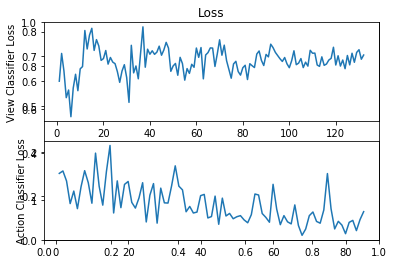

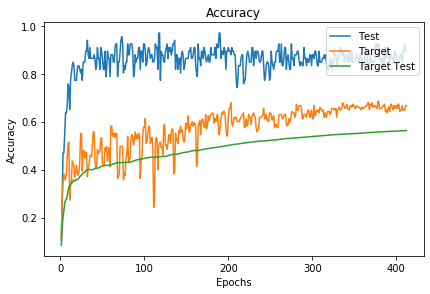

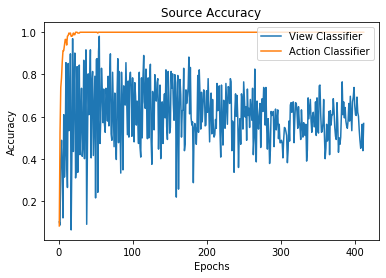

In [ ]:
train_upsample_loading(upsampling,dataset,epochs = EPOCHS,batch_size = 10)
ensure_dir('../images/')
import matplotlib.pyplot as plt
fig = plt.figure()
plt.tight_layout() 
plt.title('Loss')
ax1 = fig.add_subplot(2,1,1)
plt.ylabel('View Classifier Loss')
ax1.plot(np.arange(1,len([a.numpy() for a in VC_LOSS_list])+1,1),[a.numpy() for a in VC_LOSS_list])
ax2 = fig.add_subplot(2,1,2)
plt.ylabel('Action Classifier Loss')
ax2.plot(np.arange(1,len([a.numpy() for a in AC_LOSS_list])+1,1), [a.numpy() for a in AC_LOSS_list])
fig.savefig('../images/'+RUN_NAME + '_loss.png')

plt.figure()
plt.title('Accuracy')
plt.tight_layout() 
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(np.arange(1,len([a.numpy() for a in AC_TEST_ACCURACIES])+1,1),[a.numpy() for a in AC_TEST_ACCURACIES])
plt.plot(np.arange(1,len([a.numpy() for a in AC_TARGET_ACCURACIES])+1,1),[a.numpy() for a in AC_TARGET_ACCURACIES])
plt.plot(np.arange(1,len([a.numpy() for a in AC_TARGET_TEST_ACCURACIES])+1,1),[a.numpy() for a in AC_TARGET_TEST_ACCURACIES])
plt.legend(['Test', 'Target', 'Target Test'], loc='upper right')
fig.savefig('../images/'+RUN_NAME + '_accuracies.png')

plt.figure()
plt.title('Source Accuracy')
#plt.tight_layout() 
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(np.arange(1,len([a.numpy() for a in VC_SOURCE_ACCURACIES])+1,1), [a.numpy() for a in VC_SOURCE_ACCURACIES])
plt.plot(np.arange(1,len([a.numpy() for a in AC_SOURCE_ACCURACIES])+1,1), [a.numpy() for a in AC_SOURCE_ACCURACIES])
plt.legend(['View Classifier', 'Action Classifier'], loc='upper right')
plt.savefig('../images/'+RUN_NAME + 'source_accuracies.png')

import json
results_path = '../results/'
ensure_dir(results_path)
with open(RUN_NAME +'_results.json', 'w') as fp:
    json.dump(EXPERIMENT_RESULTS_DICT, fp)

In [ ]:
ensure_dir('../images/')
import matplotlib.pyplot as plt
fig = plt.figure()
plt.tight_layout() 
plt.title('Loss')
ax1 = fig.add_subplot(2,1,1)
plt.ylabel('View Classifier Loss')
ax1.plot(np.arange(1,len([a.numpy() for a in VC_LOSS_list])+1,1),[a.numpy() for a in VC_LOSS_list])
ax2 = fig.add_subplot(2,1,2)
plt.ylabel('Action Classifier Loss')
ax2.plot(np.arange(1,len([a.numpy() for a in AC_LOSS_list])+1,1), [a.numpy() for a in AC_LOSS_list])
fig.savefig('../images/'+RUN_NAME + '_loss.png')

plt.figure()
plt.title('Accuracy')
plt.tight_layout() 
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(np.arange(1,len([a.numpy() for a in AC_TEST_ACCURACIES])+1,1),[a.numpy() for a in AC_TEST_ACCURACIES])
plt.plot(np.arange(1,len([a.numpy() for a in AC_TARGET_ACCURACIES])+1,1),[a.numpy() for a in AC_TARGET_ACCURACIES])
plt.plot(np.arange(1,len([a.numpy() for a in AC_TARGET_TEST_ACCURACIES])+1,1),[a.numpy() for a in AC_TARGET_TEST_ACCURACIES])
plt.legend(['Test', 'Target', 'Target Test'], loc='upper right')
fig.savefig('../images/'+RUN_NAME + '_accuracies.png')

plt.figure()
plt.title('Source Accuracy')
#plt.tight_layout() 
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(np.arange(1,len([a.numpy() for a in VC_SOURCE_ACCURACIES])+1,1), [a.numpy() for a in VC_SOURCE_ACCURACIES])
plt.plot(np.arange(1,len([a.numpy() for a in AC_SOURCE_ACCURACIES])+1,1), [a.numpy() for a in AC_SOURCE_ACCURACIES])
plt.legend(['View Classifier', 'Action Classifier'], loc='upper right')
plt.savefig('../images/'+RUN_NAME + 'source_accuracies.png')


In [ ]:
plt.figure()
plt.title('Accuracy')
plt.tight_layout() 
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(np.arange(1,len([a.numpy() for a in AC_TEST_ACCURACIES])+1,1),[a.numpy() for a in AC_TEST_ACCURACIES])
plt.plot(np.arange(1,len([a.numpy() for a in AC_TARGET_ACCURACIES])+1,1),[a.numpy() for a in AC_TARGET_ACCURACIES])
plt.plot(np.arange(1,len([a.numpy() for a in AC_TARGET_TEST_ACCURACIES])+1,1),[a.numpy() for a in AC_TARGET_TEST_ACCURACIES])
plt.legend(['Test', 'Target', 'Target Test'], loc='upper right')
fig.savefig('../images/'+RUN_NAME + '_accuracies.png')

In [ ]:
import json
results_path = '../results/'
ensure_dir(results_path)
with open(RUN_NAME +'_results.json', 'w') as fp:
    json.dump(EXPERIMENT_RESULTS_DICT, fp)

In [ ]:
EXPERIMENT_RESULTS_DICT


In [ ]:
results_dict['IXMAS_allocentric']

In [ ]:
tf.keras.models.save_model(upsampling.predict_label, '../saving_trial')

In [ ]:
!saved_model_cli show --dir ../saving_trial --tag_set serve --signature_def serving_default


The given SavedModel SignatureDef contains the following input(s):
  inputs['sequential_24_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 8, 7, 7, 832)
      name: serving_default_sequential_24_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['sequential_23'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 20)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


TypeError: ignored

In [ ]:
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (48,52,3),classes = 11)
inputs = tf.keras.Input(shape=(48,52,3))
x = base_model.get_layer('block1_conv1')(inputs)
x = base_model.get_layer('block1_conv2')(x)
x = base_model.get_layer('block1_pool')(x)
x = base_model.get_layer('block2_conv1')(x)
y = Flatten()(x)
outputs = tf.keras.layers.Dense(11, activation=tf.nn.softmax)(y)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0002),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

58892288/58889256 [==============================] - 5s 0us/step


In [ ]:
@tf.function
def single_train_ranger(model,x_class, y_class, views_class, x_domain, views_domain):
    domain_labels = tf.concat([views_class, views_domain], axis = 0)
    x_both = tf.concat([x_class, x_domain], axis = 0)

    with tf.GradientTape() as tape:
        y_class_pred = model.predict_label(x_class, training=True)
        lp_loss = tf.multiply(2.0, model.loss(y_class, y_class_pred))
        tf.print('lp_loss', lp_loss)
        lp_grad = tape.gradient(lp_loss, model.predict_label.trainable_variables)

       # with tf.GradientTape() as tape:    
       #   y_domain_pred = self.classify_domain(x_both, training=True)
       #   inv_loss = self.inv_loss(domain_labels, y_domain_pred)
       #   tf.print('inv_loss', inv_loss)
       #°°   fe_grad = tape.gradient(inv_loss, self.classify_domain.trainable_variables)

    with tf.GradientTape(persistent = True) as tape:
        y_domain_pred = model.classify_domain(x_both, training=True)
        dc_loss = model.loss(domain_labels, y_domain_pred)
          
        tf.print('dc_loss', dc_loss)
        dc_grad = tape.gradient(tf.multiply(3.0,dc_loss), model.domain_classifier.trainable_variables)
          
        fe_inv_grad = tape.gradient(dc_loss, model.classify_domain.trainable_variables)
       
        #with tf.GradientTape(persistent = True) as tape:
        #  y_domain_pred2 = self.classify_domain2(x_both, training=True)
        #  dc_loss2 = self.loss(domain_labels, y_domain_pred2)
          
        #  tf.print('dc_loss2', dc_loss2)
        #  dc_grad2 = tape.gradient(dc_loss2, self.domain_classifier2.trainable_variables)
        #  downsample2_grad = tape.gradient(dc_loss2, self.classify_domain2.trainable_variables)

        model.ranger.apply_gradients(zip(lp_grad, model.predict_label.trainable_variables))
        #self.fe_optimizer.apply_gradients(zip(fe_grad, self.classify_domain.trainable_variables))
        model.ranger.apply_gradients(zip(dc_grad, model.domain_classifier.trainable_variables))
        #self.dc_optimizer.apply_gradients(zip(dc_grad2, self.domain_classifier2.trainable_variables))
        #self.dc_optimizer.apply_gradients(zip(dc_grad3, self.domain_classifier_features.trainable_variables))
        #self.fe_optimizer.apply_gradients(zip(fe_grad, self.feature_extractor.trainable_variables))
        #self.fe_optimizer.apply_gradients(zip(downsample2_grad, self.downsample.trainable_variables))
        #self.fe_optimizer.apply_gradients(zip(dc_features_grad, self.feature_extractor.trainable_variables))
        model.ranger.apply_gradients(zip(fe_inv_grad, model.feature_extractor.trainable_variables))

        
        del tape

In [ ]:
x1 = np.squeeze(tf.reshape(upsampling.return_latent_variables(dataset.x_train), (upsampling.return_latent_variables(dataset.x_train).shape[0], 48,52,3)))
x2 = np.squeeze(upsampling.return_latent_variables(dataset.x_target_test))
x_val = np.squeeze(tf.reshape(upsampling.return_latent_variables(dataset.x_val), (upsampling.return_latent_variables(dataset.x_val).shape[0], 48,52,3)))
y_val = dataset.y_val
y1 = dataset.y_train
y2 = dataset.y_target_test
y3 = dataset.y_test
#view1 = dataset.view_source
#view2 = dataset.view_target
#x = tf.concat([x1, x2], axis = 0)
#views = tf.concat([view1, view2], axis = 0)
model.fit(x1, y1, batch_size = 10, epochs = 10, verbose = True, validation_data = (x_val, y_val))

Train on 1056 samples, validate on 264 samples
Epoch 1/10
1056/1056 [==============================] - 1s 542us/sample - loss: 9.7421e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0693 - val_sparse_categorical_accuracy: 0.8144
Epoch 2/10
1056/1056 [==============================] - 1s 525us/sample - loss: 8.9127e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0784 - val_sparse_categorical_accuracy: 0.8144
Epoch 3/10
1056/1056 [==============================] - 1s 529us/sample - loss: 8.0548e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0804 - val_sparse_categorical_accuracy: 0.8144
Epoch 4/10
1056/1056 [==============================] - 1s 545us/sample - loss: 7.4809e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0763 - val_sparse_categorical_accuracy: 0.8144
Epoch 5/10
1056/1056 [==============================] - 1s 559us/sample - loss: 6.7643e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.0941 - val_sparse_categorical_accuracy: 0.8106
Epo

In [ ]:
model.evaluate(np.squeeze(tf.reshape(upsampling.return_latent_variables(dataset.x_target_test), (upsampling.return_latent_variables(dataset.x_target_test).shape[0], 48,52,3))), y2)

264/264 [==============================] - 0s 140us/sample - loss: 1.2251 - sparse_categorical_accuracy: 0.8220


[1.2250983049655615, 0.8219697]